# 07 Feature Engineering: あり vs なし

`00_prepare_data.ipynb` で作成した Train/Test を使い、
- Pattern1: 何も追加せずに学習（Baseline）
- Pattern2: 特徴量エンジニアリング + Frequency Encoding などを適用（Target Encodingなし）
を比較します。

In [48]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

SEED = 42
N_SPLITS = 5

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [49]:
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target']).copy()
y_train_full = train_df['target'].astype(int).copy()
X_test = test_df.drop(columns=['target']).copy()
y_test = test_df['target'].astype(int).copy()

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)
is_binary = num_class == 2

print(f'Train shape: {X_train_full.shape}')
print(f'Test shape : {X_test.shape}')
print(f'Classes    : {class_labels.tolist()}')

Train shape: (19536, 14)
Test shape : (29306, 14)
Classes    : [0, 1]


In [50]:
def calc_auc(y_true, proba):
    if is_binary:
        return roc_auc_score(y_true, proba[:, 1])
    return roc_auc_score(y_true, proba, multi_class='ovr', average='macro')

def make_lgbm_params(seed, advanced=False):
    if advanced:
        params = {
            'n_estimators': 400,
            'learning_rate': 0.04,
            'num_leaves': 31,
            'min_child_samples': 30,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.2,
            'reg_lambda': 3.0
        }
    else:
        params = {
            'n_estimators': 300,
            'learning_rate': 0.05,
            'num_leaves': 31,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.0,
            'reg_lambda': 1.0
        }

    params.update({
        'random_state': seed,
        'bagging_seed': seed,
        'feature_fraction_seed': seed,
        'data_random_seed': seed,
        'deterministic': True,
        'force_col_wise': True
    })

    if is_binary:
        params['objective'] = 'binary'
    else:
        params['objective'] = 'multiclass'
        params['num_class'] = num_class

    return params

def infer_categorical_like_columns(X_frame, max_unique=50):
    cat_cols = []
    for col in X_frame.columns:
        s = X_frame[col]
        nunique = s.nunique(dropna=True)
        if nunique < 2:
            continue
        if nunique <= max_unique and pd.api.types.is_numeric_dtype(s):
            as_int = np.allclose(s.fillna(0).to_numpy(), np.round(s.fillna(0).to_numpy()))
            if as_int:
                cat_cols.append(col)
    return cat_cols

def apply_frequency_encoding(tr, va, te, cols):
    tr_e, va_e, te_e = tr.copy(), va.copy(), te.copy()
    for col in cols:
        freq = tr_e[col].value_counts(normalize=True)
        tr_e[f'{col}__freq'] = tr_e[col].map(freq).fillna(0.0)
        va_e[f'{col}__freq'] = va_e[col].map(freq).fillna(0.0)
        te_e[f'{col}__freq'] = te_e[col].map(freq).fillna(0.0)
    return tr_e, va_e, te_e

def apply_numeric_feature_engineering(tr, va, te):
    tr_e, va_e, te_e = tr.copy(), va.copy(), te.copy()
    num_cols = tr_e.select_dtypes(include=[np.number]).columns.tolist()

    if len(num_cols) == 0:
        return tr_e, va_e, te_e

    variances = tr_e[num_cols].var().sort_values(ascending=False)
    top_cols = variances.head(min(5, len(variances))).index.tolist()

    tr_e['__num_mean'] = tr_e[top_cols].mean(axis=1)
    va_e['__num_mean'] = va_e[top_cols].mean(axis=1)
    te_e['__num_mean'] = te_e[top_cols].mean(axis=1)

    tr_e['__num_std'] = tr_e[top_cols].std(axis=1).fillna(0.0)
    va_e['__num_std'] = va_e[top_cols].std(axis=1).fillna(0.0)
    te_e['__num_std'] = te_e[top_cols].std(axis=1).fillna(0.0)

    return tr_e, va_e, te_e

def prune_overfit_features_binary(X_tr, y_tr, X_va, y_va, candidate_cols, min_train_auc=0.60, auc_gap_threshold=0.06):
    dropped = []

    if not is_binary or len(candidate_cols) == 0:
        return dropped

    for col in candidate_cols:
        tr_values = pd.to_numeric(X_tr[col], errors='coerce')
        va_values = pd.to_numeric(X_va[col], errors='coerce')

        fill_value = float(tr_values.median()) if np.isfinite(tr_values.median()) else 0.0
        tr_values = tr_values.fillna(fill_value)
        va_values = va_values.fillna(fill_value)

        if tr_values.nunique(dropna=True) < 2 or va_values.nunique(dropna=True) < 2:
            continue

        train_auc = roc_auc_score(y_tr, tr_values)
        valid_auc = roc_auc_score(y_va, va_values)

        train_auc = max(train_auc, 1.0 - train_auc)
        valid_auc = max(valid_auc, 1.0 - valid_auc)

        if train_auc >= min_train_auc and (train_auc - valid_auc) > auc_gap_threshold:
            dropped.append(col)

    return dropped

def build_advanced_features(X_tr, y_tr, X_va, y_va, X_te):
    X_tr_e, X_va_e, X_te_e = apply_numeric_feature_engineering(X_tr, X_va, X_te)

    cat_cols = infer_categorical_like_columns(X_tr_e, max_unique=50)
    if len(cat_cols) > 0:
        X_tr_e, X_va_e, X_te_e = apply_frequency_encoding(X_tr_e, X_va_e, X_te_e, cat_cols)

    added_cols = [c for c in X_tr_e.columns if c not in X_tr.columns]
    dropped_overfit_cols = prune_overfit_features_binary(
        X_tr=X_tr_e,
        y_tr=y_tr,
        X_va=X_va_e,
        y_va=y_va,
        candidate_cols=added_cols,
        min_train_auc=0.60,
        auc_gap_threshold=0.06
    )

    if len(dropped_overfit_cols) > 0:
        X_tr_e = X_tr_e.drop(columns=dropped_overfit_cols, errors='ignore')
        X_va_e = X_va_e.drop(columns=dropped_overfit_cols, errors='ignore')
        X_te_e = X_te_e.drop(columns=dropped_overfit_cols, errors='ignore')

    return X_tr_e, X_va_e, X_te_e, cat_cols, dropped_overfit_cols

In [51]:
def run_pattern(method_name, advanced=False):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_rows = []
    test_proba_folds = []
    used_cat_cols = []
    dropped_overfit_cols_all = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx].copy()
        y_tr = y_train_full.iloc[tr_idx].copy()
        X_va = X_train_full.iloc[va_idx].copy()
        y_va = y_train_full.iloc[va_idx].copy()
        X_te = X_test.copy()

        if advanced:
            X_tr, X_va, X_te, cat_cols, dropped_overfit_cols = build_advanced_features(X_tr, y_tr, X_va, y_va, X_te)
            used_cat_cols.extend(cat_cols)
            dropped_overfit_cols_all.extend(dropped_overfit_cols)

        params = make_lgbm_params(SEED + fold, advanced=advanced)
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='binary_logloss' if is_binary else 'multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        tr_proba = model.predict_proba(X_tr)
        tr_pred = model.predict(X_tr)
        va_proba = model.predict_proba(X_va)
        va_pred = model.predict(X_va)
        te_proba = model.predict_proba(X_te)
        te_pred = np.argmax(te_proba, axis=1)

        test_proba_folds.append(te_proba)

        for metrics in [
            {'Split': 'Train', 'Accuracy': accuracy_score(y_tr, tr_pred), 'F1_macro': f1_score(y_tr, tr_pred, average='macro'), 'LogLoss': log_loss(y_tr, tr_proba, labels=class_labels), 'AUC': calc_auc(y_tr, tr_proba)},
            {'Split': 'Valid', 'Accuracy': accuracy_score(y_va, va_pred), 'F1_macro': f1_score(y_va, va_pred, average='macro'), 'LogLoss': log_loss(y_va, va_proba, labels=class_labels), 'AUC': calc_auc(y_va, va_proba)},
            {'Split': 'Test',  'Accuracy': accuracy_score(y_test, te_pred), 'F1_macro': f1_score(y_test, te_pred, average='macro'), 'LogLoss': log_loss(y_test, te_proba, labels=class_labels), 'AUC': calc_auc(y_test, te_proba)}
        ]:
            fold_rows.append({
                'Method': method_name,
                'Fold': fold,
                'Split': metrics['Split'],
                'Accuracy': metrics['Accuracy'],
                'F1_macro': metrics['F1_macro'],
                'LogLoss': metrics['LogLoss'],
                'AUC': metrics['AUC']
            })

    fold_df = pd.DataFrame(fold_rows)
    mean_df = fold_df.groupby(['Method', 'Split'], as_index=False)[['Accuracy', 'F1_macro', 'LogLoss', 'AUC']].mean()

    test_proba_mean = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
    test_pred_mean = np.argmax(test_proba_mean, axis=1)

    extras = {
        'used_cat_like_cols': sorted(list(set(used_cat_cols))),
        'dropped_overfit_cols': sorted(list(set(dropped_overfit_cols_all)))
    }

    return fold_df, mean_df, test_pred_mean, test_proba_mean, extras

In [52]:
baseline_fold_df, baseline_mean_df, baseline_test_pred, baseline_test_proba, baseline_extras = run_pattern(
    method_name='Pattern1(Baseline)',
    advanced=False
)

advanced_fold_df, advanced_mean_df, advanced_test_pred, advanced_test_proba, advanced_extras = run_pattern(
    method_name='Pattern2(FeatureEng+FreqEnc)',
    advanced=True
)

print('Advanced mode categorical-like columns:')
print(advanced_extras['used_cat_like_cols'])
print('Advanced mode dropped-overfit features:')
print(advanced_extras['dropped_overfit_cols'])

display(baseline_fold_df.head())
display(advanced_fold_df.head())

[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AUC
0,Pattern1(Baseline),1,Train,0.896532,0.849989,0.232292,0.954458
1,Pattern1(Baseline),1,Valid,0.879478,0.823489,0.271508,0.931448
2,Pattern1(Baseline),1,Test,0.872893,0.814845,0.279257,0.926968
3,Pattern1(Baseline),2,Train,0.897946,0.852459,0.231957,0.954634
4,Pattern1(Baseline),2,Valid,0.869721,0.809395,0.283172,0.926161


,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AUC
0,Pattern2(FeatureEng+FreqEnc),1,Train,0.896724,0.850221,0.234347,0.953802
1,Pattern2(FeatureEng+FreqEnc),1,Valid,0.874360,0.815838,0.274722,0.929909
2,Pattern2(FeatureEng+FreqEnc),1,Test,0.873337,0.815378,0.280612,0.926403
3,Pattern2(FeatureEng+FreqEnc),2,Train,0.897882,0.852169,0.232889,0.954434
4,Pattern2(FeatureEng+FreqEnc),2,Valid,0.867162,0.806947,0.281893,0.926712


In [53]:
comparison_df = pd.concat([baseline_mean_df, advanced_mean_df], ignore_index=True)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)
display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')
pivot_f1 = comparison_df.pivot(index='Split', columns='Method', values='F1_macro')
pivot_logloss = comparison_df.pivot(index='Split', columns='Method', values='LogLoss')
pivot_auc = comparison_df.pivot(index='Split', columns='Method', values='AUC')

diff = pd.DataFrame({
    'Accuracy diff (Pattern2 - Pattern1)': pivot_acc['Pattern2(FeatureEng+FreqEnc)'] - pivot_acc['Pattern1(Baseline)'],
    'F1 diff (Pattern2 - Pattern1)': pivot_f1['Pattern2(FeatureEng+FreqEnc)'] - pivot_f1['Pattern1(Baseline)'],
    'LogLoss diff (Pattern2 - Pattern1)': pivot_logloss['Pattern2(FeatureEng+FreqEnc)'] - pivot_logloss['Pattern1(Baseline)'],
    'AUC diff (Pattern2 - Pattern1)': pivot_auc['Pattern2(FeatureEng+FreqEnc)'] - pivot_auc['Pattern1(Baseline)']
}).reset_index()

print('Difference by split (Pattern2 - Pattern1)')
display(diff)

,Method,Split,Accuracy,F1_macro,LogLoss,AUC
0,Pattern1(Baseline),Train,0.893914,0.845802,0.238141,0.951582
1,Pattern2(FeatureEng+FreqEnc),Train,0.895731,0.848843,0.235528,0.953008
2,Pattern1(Baseline),Valid,0.871365,0.812451,0.283001,0.925290
3,Pattern2(FeatureEng+FreqEnc),Valid,0.869318,0.809853,0.284323,0.924552
4,Pattern1(Baseline),Test,0.872524,0.814146,0.280934,0.926268
5,Pattern2(FeatureEng+FreqEnc),Test,0.872518,0.814688,0.281237,0.926152


Difference by split (Pattern2 - Pattern1)


,Split,Accuracy diff (Pattern2 - Pattern1),F1 diff (Pattern2 - Pattern1),LogLoss diff (Pattern2 - Pattern1),AUC diff (Pattern2 - Pattern1)
0,Train,0.001817,0.003041,-0.002613,0.001426
1,Valid,-0.002047,-0.002598,0.001322,-0.000738
2,Test,-0.000007,0.000542,0.000303,-0.000116


Test prediction agreement (Pattern1 vs Pattern2): 0.9863


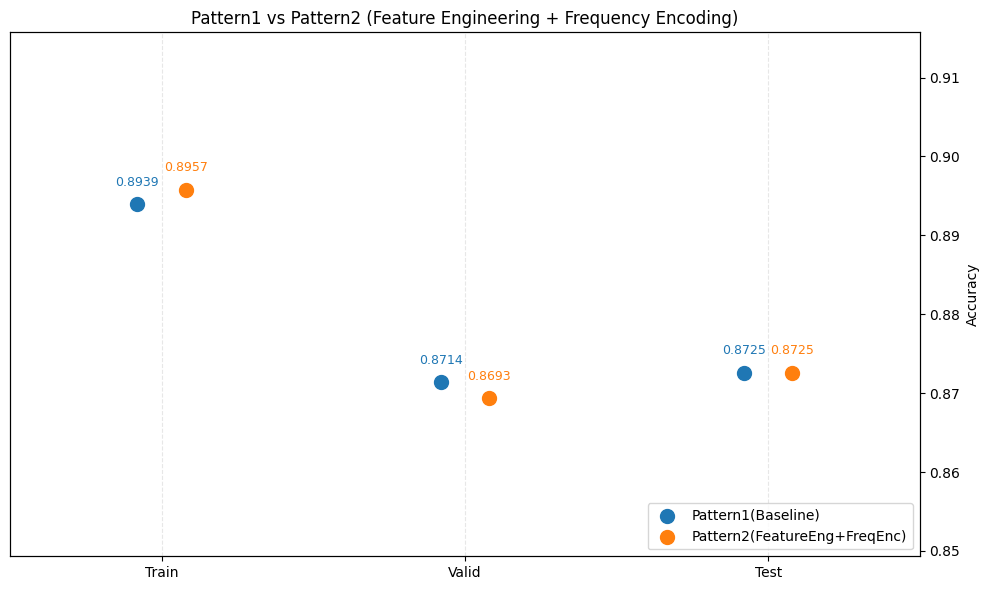

In [54]:
agreement = (baseline_test_pred == advanced_test_pred).mean()
print(f'Test prediction agreement (Pattern1 vs Pattern2): {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_p1 = [pivot_acc.loc[s, 'Pattern1(Baseline)'] for s in split_order]
acc_p2 = [pivot_acc.loc[s, 'Pattern2(FeatureEng+FreqEnc)'] for s in split_order]

fig, ax = plt.subplots(figsize=(10, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_p1, s=100, label='Pattern1(Baseline)', color='tab:blue')
ax_right.scatter(x + offset, acc_p2, s=100, label='Pattern2(FeatureEng+FreqEnc)', color='tab:orange')

for i, score in enumerate(acc_p1):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_p2):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_p1 + acc_p2)
ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower right')

plt.title('Pattern1 vs Pattern2 (Feature Engineering + Frequency Encoding)')
plt.tight_layout()
plt.show()